In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Load the data
Transform the data to the required size of the Xception model and also normalize it

In [2]:
test_datadir="../input/100-bird-species/birds/test"
train_datadir="../input/100-bird-species/birds/train"
valid_datadir="../input/100-bird-species/birds/valid"

transform=transforms.Compose([
    transforms.Resize([299,299]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data=datasets.ImageFolder(train_datadir,transform)
test_data=datasets.ImageFolder(test_datadir,transform)
valid_data=datasets.ImageFolder(valid_datadir,transform)

batchsize=24

train_dataloader=torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_data, batch_size=batchsize, shuffle=True)
valid_dataloader=torch.utils.data.DataLoader(valid_data, batch_size=batchsize, shuffle=True)

tensor(249)


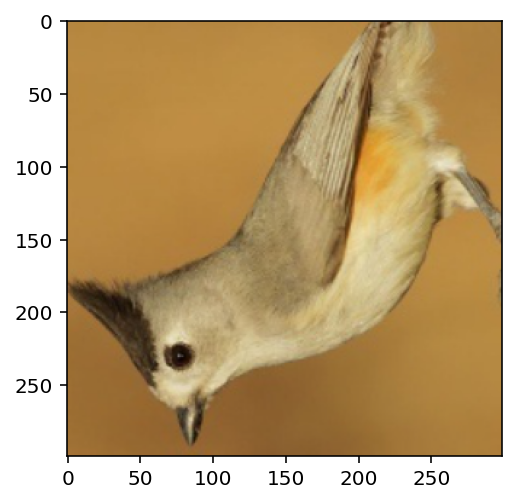

In [3]:
# Example display - 

img,label=next(iter(train_dataloader))
img = img.numpy()
img = img / 2 + 0.5 
plt.imshow(np.transpose(img[1], (2, 1, 0)))
print(label[1])

### Below we have used the Xception model - 

[--> Xception Paper link <--](https://paperswithcode.com/paper/xception-deep-learning-with-depthwise-1)

In [6]:
class Xception_implementation(nn.Module):
    def __init__(self):
        super(Xception_implementation,self).__init__()

        self.c1=nn.Conv2d(3,32,3,stride=2)
        self.bn1=nn.BatchNorm2d(32)

        self.c2=nn.Conv2d(32,64,3)
        self.bn2=nn.BatchNorm2d(64)

        self.c3=nn.Conv2d(64,128,1,stride=2)
        self.bn3=nn.BatchNorm2d(128)

        self.c4=nn.Conv2d(128,256,1,stride=2)
        self.bn4=nn.BatchNorm2d(256)

        self.c5=nn.Conv2d(256,728,1,stride=2)
        self.bn5=nn.BatchNorm2d(728)

        self.c6=nn.Conv2d(728,728,1,stride=2)
        #self.bn5=nn.BatchNorm2d(728)

        self.c7=nn.Conv2d(728,1024,1,stride=2)
        self.bn6=nn.BatchNorm2d(1024)


        self.sc1a=nn.Conv2d(64,64,3,groups=64,padding=1,bias=False)
        self.sc1b=nn.Conv2d(64,128,1,bias=False)
        #self.bn3=nn.BatchNorm2d(128)

        self.sc2a=nn.Conv2d(128,128,3,groups=128,padding=1,bias=False)
        self.sc2b=nn.Conv2d(128,128,1,bias=False)
        #self.bn3=nn.BatchNorm2d(128)

        self.sc3a=nn.Conv2d(128,128,3,groups=128,padding=1,bias=False)
        self.sc3b=nn.Conv2d(128,256,1,bias=False)
        #self.bn4=nn.BatchNorm2d(256)

        self.sc4a=nn.Conv2d(256,256,3,groups=256,padding=1,bias=False)
        self.sc4b=nn.Conv2d(256,256,1,bias=False)
        #self.bn4=nn.BatchNorm2d(256)

        self.sc5a=nn.Conv2d(256,256,3,groups=256,padding=1,bias=False)
        self.sc5b=nn.Conv2d(256,728,1,bias=False)
        #self.bn5=nn.BatchNorm2d(728)

        self.sc6a=nn.Conv2d(728,728,3,groups=728,padding=1,bias=False)
        self.sc6b=nn.Conv2d(728,728,1,bias=False)
        #self.bn5=nn.BatchNorm2d(728)

        self.sc7a=nn.Conv2d(728,728,3,groups=728,padding=1,bias=False)
        self.sc7b=nn.Conv2d(728,1024,1,bias=False)
        #self.bn6=nn.BatchNorm2d(1024)

        self.sc8a=nn.Conv2d(1024,1024,3,groups=1024,padding=1,bias=False)
        self.sc8b=nn.Conv2d(1024,1536,1,bias=False)
        self.bn7=nn.BatchNorm2d(1536)

        self.sc9a=nn.Conv2d(1536,1536,3,groups=1536,padding=1,bias=False)
        self.sc9b=nn.Conv2d(1536,2048,1,bias=False)
        self.bn8=nn.BatchNorm2d(2048)

        self.fc1=nn.Linear(2048,512)
        self.ol=nn.Linear(512,275)
       


        self.maxpool=nn.MaxPool2d(kernel_size=(3,3),stride=2,padding=1)
        self.avgpool=nn.AvgPool2d(kernel_size=(10,10))
        


    def forward(self,x):
        x=self.c1(x)
        x=self.bn1(x)
        x=F.relu(x)

        x=self.c2(x)
        x=self.bn2(x)
        x=F.relu(x)
        output=self.c3(x)
        output=self.bn3(output)

        x=self.sc1b(self.sc1a(x))
        x=self.bn3(x)
        x=F.relu(x)
        x=self.sc2b(self.sc2a(x))
        x=self.bn3(x)
        x=self.maxpool(x)

        x=x+output
        output=self.c4(output)
        output=self.bn4(output)

        x=self.sc3b(self.sc3a(F.relu(x)))
        x=self.bn4(x)
        x=self.sc4b(self.sc4a(F.relu(x)))
        x=self.bn4(x)
        x=self.maxpool(x)

        x=x+output
        output=self.c5(output)
        output=self.bn5(output)
        
        x=self.sc5b(self.sc5a(F.relu(x)))
        x=self.bn5(x)
        x=self.sc6b(self.sc6a(F.relu(x)))
        x=self.bn5(x)
        x=self.maxpool(x)

        x=x+output

        output=x
        for _ in range(8):
            x=self.sc6b(self.sc6a(F.relu(x)))
            x=self.bn5(x)
            x=self.sc6b(self.sc6a(F.relu(x)))
            x=self.bn5(x)
            x=self.sc6b(self.sc6a(F.relu(x)))
            x=self.bn5(x)
            x=x+output
        
        output=self.c7(x)
        output=self.bn6(output)

        x=self.sc6b(self.sc6a(F.relu(x)))
        x=self.bn5(x)
        x=self.sc7b(self.sc7a(F.relu(x)))
        x=self.bn6(x)
        x=self.maxpool(x)

        x=x+output

        x=self.sc8b(self.sc8a(x))
        x=self.bn7(x)
        x=F.relu(x)
        x=self.sc9b(self.sc9a(x))
        x=self.bn8(x)
        x=F.relu(x)

        x=self.avgpool(x)
        x = x.view(x.size(0), -1) 

        x=F.relu(self.fc1(x))
        x=F.relu(self.ol(x))
        return x


model = Xception_implementation()
#print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

from torchsummary import summary
summary(model,(3,299,299))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 149, 149]        896
├─BatchNorm2d: 1-2                       [-1, 32, 149, 149]        64
├─Conv2d: 1-3                            [-1, 64, 147, 147]        18,496
├─BatchNorm2d: 1-4                       [-1, 64, 147, 147]        128
├─Conv2d: 1-5                            [-1, 128, 74, 74]         8,320
├─BatchNorm2d: 1-6                       [-1, 128, 74, 74]         256
├─Conv2d: 1-7                            [-1, 64, 147, 147]        576
├─Conv2d: 1-8                            [-1, 128, 147, 147]       8,192
├─BatchNorm2d: 1-9                       [-1, 128, 147, 147]       (recursive)
├─Conv2d: 1-10                           [-1, 128, 147, 147]       1,152
├─Conv2d: 1-11                           [-1, 128, 147, 147]       16,384
├─BatchNorm2d: 1-12                      [-1, 128, 147, 147]       (recursive)
├─MaxPool2d: 1-13                        [-1, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 149, 149]        896
├─BatchNorm2d: 1-2                       [-1, 32, 149, 149]        64
├─Conv2d: 1-3                            [-1, 64, 147, 147]        18,496
├─BatchNorm2d: 1-4                       [-1, 64, 147, 147]        128
├─Conv2d: 1-5                            [-1, 128, 74, 74]         8,320
├─BatchNorm2d: 1-6                       [-1, 128, 74, 74]         256
├─Conv2d: 1-7                            [-1, 64, 147, 147]        576
├─Conv2d: 1-8                            [-1, 128, 147, 147]       8,192
├─BatchNorm2d: 1-9                       [-1, 128, 147, 147]       (recursive)
├─Conv2d: 1-10                           [-1, 128, 147, 147]       1,152
├─Conv2d: 1-11                           [-1, 128, 147, 147]       16,384
├─BatchNorm2d: 1-12                      [-1, 128, 147, 147]       (recursive)
├─MaxPool2d: 1-13                        [-1, 

## Adjusting different parameters - 
We are using Xception paper model and therefore the hyper-parameters (number of layers and their size) is fixed. Therefore we are left with the following parameters- 
1. Optimizer- We will try 2 -  Adam and SGD (with momentum)
2. lr - We will try different ranges of lr to get to most suitable value
3. batch-size - Though I have a little problem of memory issues and theefore I cannot try a large range of Batch-size, but still I try to achieve the sweet spot.
4. Logistic NN after the Xception part of the Neural Network

#### For lr=0.01, optimizer= Adam, batch_size=24 -
number of batches- 100  
Test loss-         5.802419457435608  
200  
5.709594624042511  
300  
5.678653012911479  
400  
5.663182207345963  
500  
5.653899754524231  
600  
5.647711427211761  
700  
5.643291193417141  
800  
5.639976018071175  
900  
5.6373975483576455  
1000  
5.635334772586822  

##### Conclusion:  
The values are reaching the limit very early, therefore its possible that our ls is very large due to which its just oscillating around a local minima or its very small that its not moving significantly.  
We will first try to increase the lr.
  

#### For lr=0.03, optimizer= Adam, batch_size=24 -
100  
6.1476314258575435  
200  
5.882200617790222  
300  
5.793723675409953  
400  
5.749485204219818  
500  
5.722942131996155  

##### Conclusion:  
Though its a bad performance campared to the previous test, therefore we conclude that our lr is very large for the data. But, to double confirm this, we will run it one more time with larger lr.
  
  
#### For lr=0.09, optimizer= Adam, batch_size=24 -
100  
16.719118494987487  
200  
11.16794414281845  
300  
9.317552692095438  
400  
8.392356966733933  
500  
7.837239531517029  

##### Conclusion:  
Our caonclusion is confirmed and now we will run many different tests, decreasing the lr slowly, till we reach a sweet spot.


#### For lr=0.005, optimizer= Adam, batch_size=24 -

100  
5.643889384269714  
200  
5.630329587459564  
300  
5.6258096551895145  
400  
5.623549689054489  
500  
5.622193709373474  

##### Conclusion:  
We are seeing improvements.  
Lets keep decreasing the lr.
  
#### For lr=0.001, optimizer= Adam, batch_size=24 -

100  
5.622370572090149  
200  
5.61957022190094  
300  
5.618636751174927  
400  
5.618170011043548  
500  
5.6178899669647215  

##### Conclusion:  
We are seeing improvements.  
Lets keep decreasing the lr.

#### For lr=0.0005, optimizer= Adam, batch_size=24 -
100  
5.612162141799927  
200  
5.610788090229034  
300  
5.609323104222615  
400  
5.608894389867783  
500  
5.610006352424621  

##### Conclusion:  
Its a rough spot. Maybe lr=0.001 was better. But its almost the same results, and we should try decreasing the lr again.

#### For lr=0.0001, optimizer= Adam, batch_size=24 -
100  
5.594290690422058  
200  
5.586528244018555  
300  
5.56579353650411  
400  
5.5533226096630095  
500  
5.540951251029968  
600  
5.531232864061991  

##### Conclusion:  
Definately a big improvement. Also notice that the decrease in loss with 100 batches is also increasing.  
This means we are on right track and lets keep reducing the lr.

#### For lr=0.00005, optimizer= Adam, batch_size=24 -
100  
5.59938111782074  
200  
5.577222900390625  
300  
5.549906469980876  
400  
5.527121528387069  
500  
5.503145340919494  
600  
5.4825732986132305  

##### Conclusion:  
We are seeing improvements.  
Lets keep decreasing the lr.

#### For lr=0.00001, optimizer= Adam, batch_size=24 -
100  
5.607132072448731  
200  
5.597659332752228  
300  
5.59043066183726  
400  
5.581763937473297  
500  
5.573947592735291  

##### Conclusion:  
Though not a bad performance, but lr=0.00005 was better than 0.00001 and therefore we conclude that the reducing lr further is not good.

## Therefore Lets fix lr at 0.00005  

#### Now lets focus on Logistic NN part just after the Xception layers. Till now, we were using 2 layers - (2048,512,275)  

#### For lr=0.00005, optimizer= Adam, batch_size=24  and NN ( 1 layer )-
100  
5.596523351669312  
200  
5.574898626804352  
300  
5.565456638336181  
400  
5.554475079774857  
500  
5.537313059806824  

##### Conclusion:  
Performance has definately gone down.  
Instead of decreasing, lets try to increase the number of layers.

#### For lr=0.00005, optimizer= Adam, batch_size=24  and NN ( 3 layers - 2048,1024,512,275 )-

100  
5.606496725082398  
200  
5.5884935927391055  
300  
5.564859512646993  
400  
5.549061695337295  
500  
5.530344123840332  
600  
5.517454077402751  

##### Conclusion:  
Nope.  
The performance has again gone down.  
2 layered network was better.  

## Therefore, lets keep the NN as 2 layered - 2048,512,275

#### Now lets focus on the optimizer and try SGD with different lr.  
#### For lr=0.00005, optimizer= SGD, batch_size=24 -
100  
5.615721163749694  
200  
5.613029680252075  
300  
5.610925540924073  
400  
5.609257943630219  
500  
5.606311025619507  
600  
5.604059344132741  
700  
5.600591844149998  
800  
5.597238064408303  
900  
5.59338313208686  
1000  
5.590157297611237  

##### Conclusion:  
Not a good performance compared to Adam.  
Maybe changing the lr will help.  
Lets increase the lr.

#### For lr=0.0001, optimizer= SGD, batch_size=24 -
100  
5.620724911689758  
200  
5.619467494487762  
300  
5.617840498288473  
400  
5.617654368877411  
500  
5.6167002849578855  
600  
5.615881765683492  

##### Conclusion:  
Almost the same performance as the previous one.  
Lets increse the lr more and compare the results.

#### For lr=0.0005, optimizer= SGD, batch_size=24 -
100  
5.614914889335632  
200  
5.611899130344391  
300  
5.610926251411438  
400  
5.609055856466293  
500  
5.606855712890625  

##### Conclusion:  
Though its an improvement.  
But we can see that the change in loss in very less and therefore in a few more steps it will change negligibly.  
We will try decresing the lr to see if major change in lr is observed.

#### For lr=0.00001, optimizer= SGD, batch_size=24 -
100  
5.617706594467163  
200  
5.618453540802002  
300  
5.618358642260233  
400  
5.6184623348712925  
500  
5.618501291275025  

##### Conclusion:  
Our previous problem still stands.
The Loss is decreasing negligibly.  



## Therefore, its better if we stick with Adam.

NOTE : I tried changing the batch-size but it had almost no effect on values, moreover, increasing it to more than 24 is giving Memory issues and therefore, we will remain with 24 as the batch-size.  
Therefore, the final choosen values are-  
1. lr = 0.00005
2. Logictic NN after Xception - 2 layers (2048,512,275)
3. Optimizer- Adam
4. Batch-size = 24

In [7]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
#optimizer = optim.SGD(model.parameters(),lr=0.0005,momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.00005)

In [ ]:
n_epochs = 10 
valid_loss_min = np.Inf # track change in validation loss
batch_number=0
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    for data, target in train_dataloader:
        batch_number+=1
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss

        
        loss = criterion(output, target)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        if batch_number%100==0:
            print(batch_number)
            #print(train_loss/(24*batch_number))
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_dataloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_dataloader.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_bird_species.pt')
        valid_loss_min = valid_loss

In [9]:
torch.save(model.state_dict(), 'model_bird_species_2.pt')

### Testing 
We have trained and saved 2 models -
1. model_bird_species - is the model where we are getting the min Validation loss ( but high training loss)
2. model_bird_species_2 - is the model where are fitting the data efficiently to the training data but have high loss in validation data  

Choose 1 saved model in the below code to see the what accuracy we are getting on each model.

In [8]:
# Choose 1 from the below 2-
model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species.pt'))
#model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_2.pt'))

test_loss = 0.0
class_correct = list(0. for i in range(275))
class_total = list(0. for i in range(275))

model.eval()
# iterate over test data
for data, target in test_dataloader:
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = model(data)    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    batchsize=data.size(0)
    for i in range(batchsize):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(275):
    if class_total[i] > 0:
        print('Test Accuracy of class %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 5.920999

Test Accuracy of class     0:  0% ( 0/ 5)
Test Accuracy of class     1:  0% ( 0/ 5)
Test Accuracy of class     2:  0% ( 0/ 5)
Test Accuracy of class     3:  0% ( 0/ 5)
Test Accuracy of class     4:  0% ( 0/ 5)
Test Accuracy of class     5:  0% ( 0/ 5)
Test Accuracy of class     6:  0% ( 0/ 5)
Test Accuracy of class     7:  0% ( 0/ 5)
Test Accuracy of class     8:  0% ( 0/ 5)
Test Accuracy of class     9:  0% ( 0/ 5)
Test Accuracy of class    10:  0% ( 0/ 5)
Test Accuracy of class    11:  0% ( 0/ 5)
Test Accuracy of class    12:  0% ( 0/ 5)
Test Accuracy of class    13:  0% ( 0/ 5)
Test Accuracy of class    14:  0% ( 0/ 5)
Test Accuracy of class    15:  0% ( 0/ 5)
Test Accuracy of class    16: 20% ( 1/ 5)
Test Accuracy of class    17:  0% ( 0/ 5)
Test Accuracy of class    18:  0% ( 0/ 5)
Test Accuracy of class    19:  0% ( 0/ 5)
Test Accuracy of class    20:  0% ( 0/ 5)
Test Accuracy of class    21:  0% ( 0/ 5)
Test Accuracy of class    22:  0% ( 0/ 5)
Test Accuracy

### Observation -
We saw that we reached the best possible validation loss in the first few epochs and the trainig loss kept on decreasing.  
Which is not very good as we want to reduce the validation loss and not necessarily the training loss.  

Maybe by randomising and making the training data more general, we may get a better validation loss (at the cost of training loss)  

Therefore, we add randomisation to our training data -

In [9]:
transform_2 = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

train_data_2=datasets.ImageFolder(train_datadir,transform_2)

train_dataloader_2=torch.utils.data.DataLoader(train_data_2, batch_size=batchsize, shuffle=True)


### Now lets train the new data again

In [11]:
n_epochs = 10 
valid_loss_min = np.Inf # track change in validation loss
batch_number=0
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    for data, target in train_dataloader_2:
        batch_number+=1
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss

        
        loss = criterion(output, target)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        if batch_number%100==0:
            print(batch_number)
            #print(train_loss/(24*batch_number))
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_dataloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_dataloader_2.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_bird_species_3.pt')
        valid_loss_min = valid_loss

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Epoch: 1 	Training Loss: 5.401516 	Validation Loss: 5.577997
Validation loss decreased (inf --> 5.577997).  Saving model ...
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
Epoch: 2 	Training Loss: 5.183081 	Validation Loss: 5.812162
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
Epoch: 3 	Training Loss: 5.062586 	Validation Loss: 5.841246


KeyboardInterrupt: 

In [12]:
torch.save(model.state_dict(), 'model_bird_species_4.pt')

### Testing 
We have trained and saved 2 more models -
1. model_bird_species_3 - is the model where we are getting the min Validation loss ( but high training loss) on new training data.
2. model_bird_species_4 - is the model where are fitting the data efficiently to the training data but have high loss in validation data. (on new training data)

Choose 1 saved model in the below code to see the what accuracy we are getting on each model.

In [10]:
# Choose one of the four available saved models- 
#model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species.pt'))
# model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_2.pt'))
model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_3.pt'))
# model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_4.pt'))

test_loss = 0.0
class_correct = list(0. for i in range(275))
class_total = list(0. for i in range(275))

model.eval()
# iterate over test data
for data, target in test_dataloader:
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = model(data)    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    batchsize=data.size(0)
    for i in range(batchsize):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(275):
    if class_total[i] > 0:
        print('Test Accuracy of class %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 5.591104

Test Accuracy of class     0:  0% ( 0/ 5)
Test Accuracy of class     1:  0% ( 0/ 5)
Test Accuracy of class     2:  0% ( 0/ 5)
Test Accuracy of class     3:  0% ( 0/ 5)
Test Accuracy of class     4:  0% ( 0/ 5)
Test Accuracy of class     5:  0% ( 0/ 5)
Test Accuracy of class     6:  0% ( 0/ 5)
Test Accuracy of class     7: 20% ( 1/ 5)
Test Accuracy of class     8: 20% ( 1/ 5)
Test Accuracy of class     9: 60% ( 3/ 5)
Test Accuracy of class    10:  0% ( 0/ 5)
Test Accuracy of class    11:  0% ( 0/ 5)
Test Accuracy of class    12:  0% ( 0/ 5)
Test Accuracy of class    13:  0% ( 0/ 5)
Test Accuracy of class    14:  0% ( 0/ 5)
Test Accuracy of class    15:  0% ( 0/ 5)
Test Accuracy of class    16:  0% ( 0/ 5)
Test Accuracy of class    17:  0% ( 0/ 5)
Test Accuracy of class    18:  0% ( 0/ 5)
Test Accuracy of class    19:  0% ( 0/ 5)
Test Accuracy of class    20: 40% ( 2/ 5)
Test Accuracy of class    21:  0% ( 0/ 5)
Test Accuracy of class    22:  0% ( 0/ 5)
Test Accuracy

### 3rd approach

In [11]:
class Xception_implementation(nn.Module):
    def __init__(self):
        super(Xception_implementation,self).__init__()

        self.c1=nn.Conv2d(3,32,3,stride=2)
        self.bn1=nn.BatchNorm2d(32)

        self.c2=nn.Conv2d(32,64,3)
        self.bn2=nn.BatchNorm2d(64)

        self.c3=nn.Conv2d(64,128,1,stride=2)
        self.bn3=nn.BatchNorm2d(128)

        self.c4=nn.Conv2d(128,256,1,stride=2)
        self.bn4=nn.BatchNorm2d(256)

        self.c5=nn.Conv2d(256,728,1,stride=2)
        self.bn5=nn.BatchNorm2d(728)

        self.c6=nn.Conv2d(728,728,1,stride=2)
        #self.bn5=nn.BatchNorm2d(728)

        self.c7=nn.Conv2d(728,1024,1,stride=2)
        self.bn6=nn.BatchNorm2d(1024)


        self.sc1a=nn.Conv2d(64,64,3,groups=64,padding=1,bias=False)
        self.sc1b=nn.Conv2d(64,128,1,bias=False)
        #self.bn3=nn.BatchNorm2d(128)

        self.sc2a=nn.Conv2d(128,128,3,groups=128,padding=1,bias=False)
        self.sc2b=nn.Conv2d(128,128,1,bias=False)
        #self.bn3=nn.BatchNorm2d(128)

        self.sc3a=nn.Conv2d(128,128,3,groups=128,padding=1,bias=False)
        self.sc3b=nn.Conv2d(128,256,1,bias=False)
        #self.bn4=nn.BatchNorm2d(256)

        self.sc4a=nn.Conv2d(256,256,3,groups=256,padding=1,bias=False)
        self.sc4b=nn.Conv2d(256,256,1,bias=False)
        #self.bn4=nn.BatchNorm2d(256)

        self.sc5a=nn.Conv2d(256,256,3,groups=256,padding=1,bias=False)
        self.sc5b=nn.Conv2d(256,728,1,bias=False)
        #self.bn5=nn.BatchNorm2d(728)

        self.sc6a=nn.Conv2d(728,728,3,groups=728,padding=1,bias=False)
        self.sc6b=nn.Conv2d(728,728,1,bias=False)
        #self.bn5=nn.BatchNorm2d(728)

        self.sc7a=nn.Conv2d(728,728,3,groups=728,padding=1,bias=False)
        self.sc7b=nn.Conv2d(728,1024,1,bias=False)
        #self.bn6=nn.BatchNorm2d(1024)

        self.sc8a=nn.Conv2d(1024,1024,3,groups=1024,padding=1,bias=False)
        self.sc8b=nn.Conv2d(1024,1536,1,bias=False)
        self.bn7=nn.BatchNorm2d(1536)

        self.sc9a=nn.Conv2d(1536,1536,3,groups=1536,padding=1,bias=False)
        self.sc9b=nn.Conv2d(1536,2048,1,bias=False)
        self.bn8=nn.BatchNorm2d(2048)

        self.fc1=nn.Linear(2048,512)
        self.ol=nn.Linear(512,275)
       


        self.maxpool=nn.MaxPool2d(kernel_size=(3,3),stride=2,padding=1)
        self.avgpool=nn.AvgPool2d(kernel_size=(10,10))
        
        self.dropout = nn.Dropout(0.4)


    def forward(self,x):
        x=self.c1(x)
        x=self.bn1(x)
        x=F.relu(x)

        x=self.c2(x)
        x=self.bn2(x)
        x=F.relu(x)
        output=self.c3(x)
        output=self.bn3(output)

        x=self.sc1b(self.sc1a(x))
        x=self.bn3(x)
        x=F.relu(x)
        x=self.sc2b(self.sc2a(x))
        x=self.bn3(x)
        x=self.maxpool(x)

        x=x+output
        output=self.c4(output)
        output=self.bn4(output)

        x=self.sc3b(self.sc3a(F.relu(x)))
        x=self.bn4(x)
        x=self.sc4b(self.sc4a(F.relu(x)))
        x=self.bn4(x)
        x=self.maxpool(x)

        x=x+output
        output=self.c5(output)
        output=self.bn5(output)
        
        x=self.sc5b(self.sc5a(F.relu(x)))
        x=self.bn5(x)
        x=self.sc6b(self.sc6a(F.relu(x)))
        x=self.bn5(x)
        x=self.maxpool(x)
        
        x = self.dropout(x)

        x=x+output

        output=x
        for _ in range(8):
            x=self.sc6b(self.sc6a(F.relu(x)))
            x=self.bn5(x)
            x=self.sc6b(self.sc6a(F.relu(x)))
            x=self.bn5(x)
            x=self.sc6b(self.sc6a(F.relu(x)))
            x=self.bn5(x)
            x=x+output
        
        x = self.dropout(x)
        
        output=self.c7(x)
        output=self.bn6(output)

        x=self.sc6b(self.sc6a(F.relu(x)))
        x=self.bn5(x)
        x=self.sc7b(self.sc7a(F.relu(x)))
        x=self.bn6(x)
        x=self.maxpool(x)

        x=x+output

        x=self.sc8b(self.sc8a(x))
        x=self.bn7(x)
        x=F.relu(x)
        x=self.sc9b(self.sc9a(x))
        x=self.bn8(x)
        x=F.relu(x)
        
        x = self.dropout(x)

        x=self.avgpool(x)
        x = x.view(x.size(0), -1) 

        x=F.relu(self.fc1(x))
        x=F.relu(self.ol(x))
        return x


model = Xception_implementation()
#print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

from torchsummary import summary
summary(model,(3,299,299))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 149, 149]        896
├─BatchNorm2d: 1-2                       [-1, 32, 149, 149]        64
├─Conv2d: 1-3                            [-1, 64, 147, 147]        18,496
├─BatchNorm2d: 1-4                       [-1, 64, 147, 147]        128
├─Conv2d: 1-5                            [-1, 128, 74, 74]         8,320
├─BatchNorm2d: 1-6                       [-1, 128, 74, 74]         256
├─Conv2d: 1-7                            [-1, 64, 147, 147]        576
├─Conv2d: 1-8                            [-1, 128, 147, 147]       8,192
├─BatchNorm2d: 1-9                       [-1, 128, 147, 147]       (recursive)
├─Conv2d: 1-10                           [-1, 128, 147, 147]       1,152
├─Conv2d: 1-11                           [-1, 128, 147, 147]       16,384
├─BatchNorm2d: 1-12                      [-1, 128, 147, 147]       (recursive)
├─MaxPool2d: 1-13                        [-1, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 149, 149]        896
├─BatchNorm2d: 1-2                       [-1, 32, 149, 149]        64
├─Conv2d: 1-3                            [-1, 64, 147, 147]        18,496
├─BatchNorm2d: 1-4                       [-1, 64, 147, 147]        128
├─Conv2d: 1-5                            [-1, 128, 74, 74]         8,320
├─BatchNorm2d: 1-6                       [-1, 128, 74, 74]         256
├─Conv2d: 1-7                            [-1, 64, 147, 147]        576
├─Conv2d: 1-8                            [-1, 128, 147, 147]       8,192
├─BatchNorm2d: 1-9                       [-1, 128, 147, 147]       (recursive)
├─Conv2d: 1-10                           [-1, 128, 147, 147]       1,152
├─Conv2d: 1-11                           [-1, 128, 147, 147]       16,384
├─BatchNorm2d: 1-12                      [-1, 128, 147, 147]       (recursive)
├─MaxPool2d: 1-13                        [-1, 

In [12]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
#optimizer = optim.SGD(model.parameters(),lr=0.0005,momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.00005)

In [9]:
n_epochs = 10 
valid_loss_min = np.Inf # track change in validation loss
batch_number=0
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    
    for data, target in train_dataloader_2:
        batch_number+=1
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss

        
        loss = criterion(output, target)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        if batch_number%100==0:
            print(batch_number)
            #print(train_loss/(24*batch_number))
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_dataloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_dataloader_2.dataset)
    valid_loss = valid_loss/len(valid_dataloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_bird_species_5.pt')
        valid_loss_min = valid_loss

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Epoch: 1 	Training Loss: 5.458202 	Validation Loss: 5.559728
Validation loss decreased (inf --> 5.559728).  Saving model ...
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
Epoch: 2 	Training Loss: 5.272828 	Validation Loss: 5.578864
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
Epoch: 3 	Training Loss: 5.173796 	Validation Loss: 5.600804
5000
5100
5200
5300
5400
5500
5600
5700
5800


KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(), 'model_bird_species_6.pt')

### Testing 
We have trained and saved 2 more models -
1. model_bird_species_5 - is the model where we are getting the min Validation loss ( but high training loss) on new training data.
2. model_bird_species_6 - is the model where are fitting the data efficiently to the training data but have high loss in validation data. (on new training data)

Choose 1 saved model in the below code to see the what accuracy we are getting on each model.

In [18]:
# Choose one of the four available saved models- 
#model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species.pt'))
#model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_2.pt'))
model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_3.pt'))
#model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_4.pt'))
#model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_5.pt'))
#model.load_state_dict(torch.load('../input/saved-model-bird-species/model_bird_species_6.pt'))

test_loss = 0.0
class_correct = list(0. for i in range(275))
class_total = list(0. for i in range(275))

model.eval()
# iterate over test data
for data, target in test_dataloader:
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = model(data)    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    batchsize=data.size(0)
    for i in range(batchsize):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(275):
    if class_total[i] > 0:
        print('Test Accuracy of class %5s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 5.591104

Test Accuracy of class     0:  0% ( 0/ 5)
Test Accuracy of class     1:  0% ( 0/ 5)
Test Accuracy of class     2:  0% ( 0/ 5)
Test Accuracy of class     3:  0% ( 0/ 5)
Test Accuracy of class     4:  0% ( 0/ 5)
Test Accuracy of class     5:  0% ( 0/ 5)
Test Accuracy of class     6:  0% ( 0/ 5)
Test Accuracy of class     7: 20% ( 1/ 5)
Test Accuracy of class     8: 20% ( 1/ 5)
Test Accuracy of class     9: 60% ( 3/ 5)
Test Accuracy of class    10:  0% ( 0/ 5)
Test Accuracy of class    11:  0% ( 0/ 5)
Test Accuracy of class    12:  0% ( 0/ 5)
Test Accuracy of class    13:  0% ( 0/ 5)
Test Accuracy of class    14:  0% ( 0/ 5)
Test Accuracy of class    15:  0% ( 0/ 5)
Test Accuracy of class    16:  0% ( 0/ 5)
Test Accuracy of class    17:  0% ( 0/ 5)
Test Accuracy of class    18:  0% ( 0/ 5)
Test Accuracy of class    19:  0% ( 0/ 5)
Test Accuracy of class    20: 40% ( 2/ 5)
Test Accuracy of class    21:  0% ( 0/ 5)
Test Accuracy of class    22:  0% ( 0/ 5)
Test Accuracy

#### Therefore, we have the following accuracies -
1. model_bird_species = 19/1375
2. model_bird_species_2 = 9/1375
3. model_bird_species_3 = 32/1375
4. model_bird_species_4 = 22/1375
5. model_bird_species_5 = 30/1375
6. model_bird_species_6 = 25/1375